# Anomaly detection

We'll demonstrate how an autoencoder can be used to determine anomalies in electrocardiograms.

_Disclaimer: This application is built for demonstration purposes only. It is not intended for use in any medical setting._

## The ECG dataset

I will use the ECG dataset, which contains 4998 examples of electrocardiogram (ECG) signals. The dataset is available for download as a csv file either at http://www.timeseriesclassification.com/description.php?Dataset=ECG5000 or via the Google cloud storage http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv. 
I will use the latter direction to download the dataset with Python, 

In [2]:
import pandas as pd

dataframe = pd.read_csv(
    "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv",
    header=None,
)
raw_data = dataframe.values

print("Size:", raw_data.shape)

Size: (4998, 141)


In [5]:
from sklearn.model_selection import train_test_split

labels = raw_data[:, -1].astype(bool)
data = raw_data[:, 2:-11]

train_data, test_data, train_labels, test_labels = train_test_split(
    data,
    labels,
    test_size=0.3,
)

In [56]:
import deeptrack as dt
import numpy as np
import torch

normal_train_data = train_data[train_labels]

m = np.min(normal_train_data)
M = np.max(normal_train_data)


def random_pick(x):
    return x[np.random.randint(0, x.shape[0])]


training_pipeline = (
    dt.Value([normal_train_data])
    >> random_pick
    >> dt.Subtract(m)
    >> dt.Divide(M - m)
    >> dt.Unsqueeze(0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

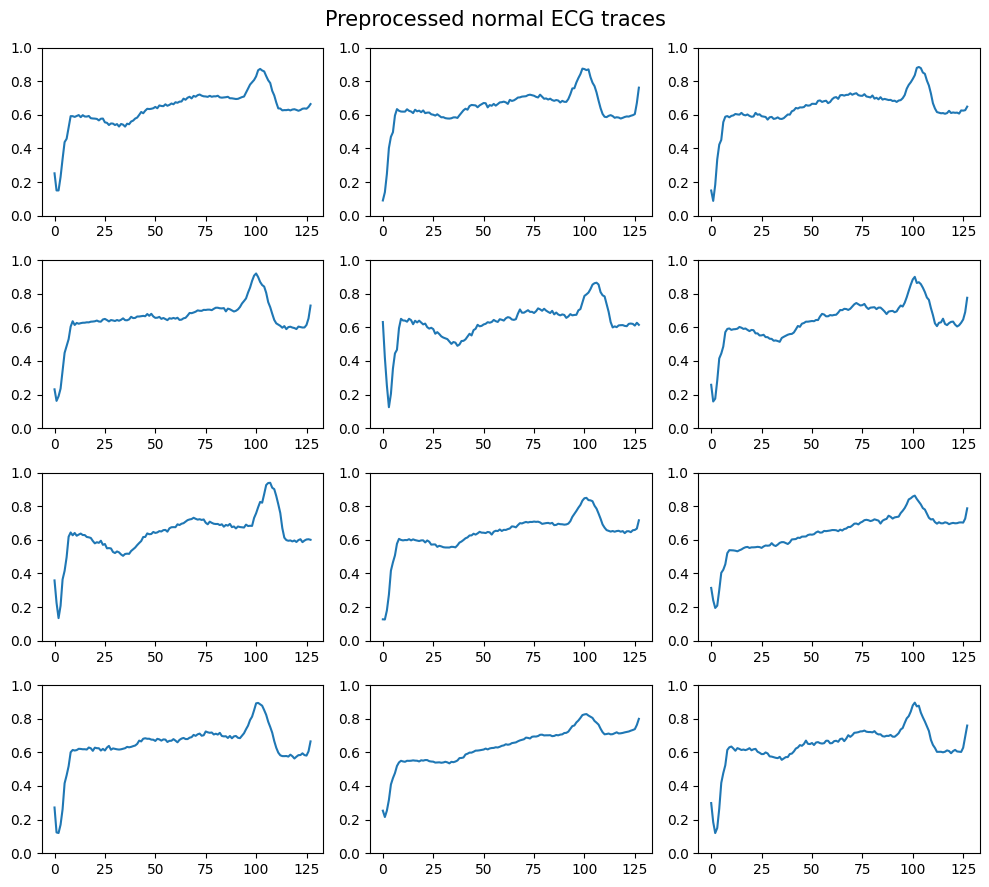

In [63]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(4, 3, figsize=((10, 9)))
fig.suptitle("Preprocessed normal ECG traces", fontsize=15)

for i in range(12):
    trace = training_pipeline.update()().squeeze()
    axs[i // 3, i % 3].plot(trace)
    axs[i // 3, i % 3].set_ylim([0, 1])

fig.tight_layout()

## Autoencoder
We define the autoencoder architecture.

In [80]:
import deeplay as dl
from torch.nn import Identity
import torch.nn as nn

autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[4, 4],
    decoder_channels=[4, 4],
    out_channels=1,
    out_activation=Identity,
)
import torch.nn as nn

autoencoder.encoder.blocks.layer.configure(nn.Conv1d, kernel_size=4, padding="same")
autoencoder.encoder.blocks.pool[1:].configure(nn.MaxPool1d, kernel_size=4, stride=1)

autoencoder.decoder.blocks.layer.configure(nn.Conv1d, kernel_size=4)
autoencoder.decoder.blocks.upsample[:-1].configure(
    nn.ConvTranspose1d, kernel_size=4, stride=4
)
# autoencoder = autoencoder.create()
print(autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv1d](in_channels=1, out_channels=4, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=4)
      )
      (1-2): 2 x PoolLayerActivationNormalization(
        (pool): Layer[MaxPool1d](kernel_size=4, stride=8)
        (layer): Layer[Conv1d](in_channels=4, out_channels=4, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=4)
      )
    )
    (postprocess): Layer[Identity]()
  )
  (decoder): ConvolutionalDecoder2d(
    (preprocess): Layer[Identity]()
    (blocks): LayerList(
      (0-1): 2 x LayerActivationNormalizationUpsample(
        (layer): Layer[Conv1d](in_channels=4, out_channels=4, kernel_size=4, stride=1, padding=1)
        (activati

In [81]:
import torchmetrics as tm
from torch.nn import L1Loss


regressor_template = dl.Regressor(
    model=autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)

autoencoder_regressor = regressor_template.create()

In [82]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(
    training_pipeline & training_pipeline,
    length=1000,
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# train_loader = DataLoader(
#     training_pipeline & training_pipeline, batch_size=8, shuffle=True
# )

autoencoder_trainer = dl.Trainer(max_epochs=15, accelerator="auto")

autoencoder_trainer.fit(autoencoder_regressor, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollecti

Training: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 1, 128])) that is different to the input size (torch.Size([64, 1, 19])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (19) must match the size of tensor b (128) at non-singleton dimension 2

In [85]:
autoencoder = autoencoder_regressor.model
autoencoder.encoder.blocks[0](torch.rand(1, 1, 128)).shape
autoencoder.encoder.blocks[1](torch.rand(1, 4, 128)).shape
autoencoder.encoder.blocks[2](torch.rand(1, 4, 16)).shape
# autoencoder.decoder.blocks[0](torch.rand(1, 4, 2)).shape

torch.Size([1, 4, 16])

In [13]:
import deeptrack as dt

encoder_pooling_block = dt.layers.PoolingBlock(
    pool_size=(8),
    strides=8,
)

encoder_unpooling_block = dt.layers.DeconvolutionalBlock(
    kernel_size=(8),
    strides=8,
)

conv_layer = dt.layers.ConvolutionalBlock(
    kernel_size=(8),
)

model = dt.models.EncoderDecoder(
    input_shape=(128, 128, 1),
    steps_per_pooling=1,
    conv_layers_dimensions=(4, 4),
    base_conv_layers_dimensions=(4,),
    output_conv_layers_dimensions=(),
    pooling_block=encoder_pooling_block,
    upsampling_block=encoder_unpooling_block,
    encoder_convolution_block=conv_layer,
    base_convolution_block=conv_layer,
    decoder_convolution_block=conv_layer,
    output_convolution_block=conv_layer,
).model

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 4)       260       
                                                                 
 activation (Activation)     (None, 128, 128, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 4)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 4)         1028      
                                                                 
 activation_1 (Activation)   (None, 16, 16, 4)         0         
                                                             

Let's see if the autoencoder is able to generalize its predictions to particles located off center and with different size.

In [29]:
new_particles = dt.Sphere(
    position=lambda: np.array([0.4, 0.4] + np.random.rand(2) * 0.2) * 64,
    z=0,
    position_unit="pixel",
    radius=lambda: 50e-8 + np.random.rand() * 50e-8,
    refractive_index=1.45 + 0.02j,
)

new_illuminated_sample = sum(
    [
        brightfield_microscope_onewl(new_particles)
        for brightfield_microscope_onewl in brightfield_microscope
    ]
)

new_clean_particles = (
    new_illuminated_sample
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

new_noisy_particles = (
    new_illuminated_sample
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

new_pipeline = (new_noisy_particles) & (new_clean_particles)

We check the predictions on this more challenging test set.

We can train on the new dataset.

In [31]:
new_train_dataset = SimulatedDatasetwithReplacement(
    new_pipeline, data_size=256, replace=0.2
)

new_train_loader = DataLoader(new_train_dataset, batch_size=8, shuffle=True)

new_autoencoder_regressor = regressor_template.create()

new_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

new_autoencoder_trainer.fit(new_autoencoder_regressor, new_train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              | 0     
3 | test_metrics  | MetricCollection              | 0     
4 | model         | ConvolutionalEncoderDecoder2d | 4.8 K 
5 | optimizer     | Adam                          | 0     
-------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


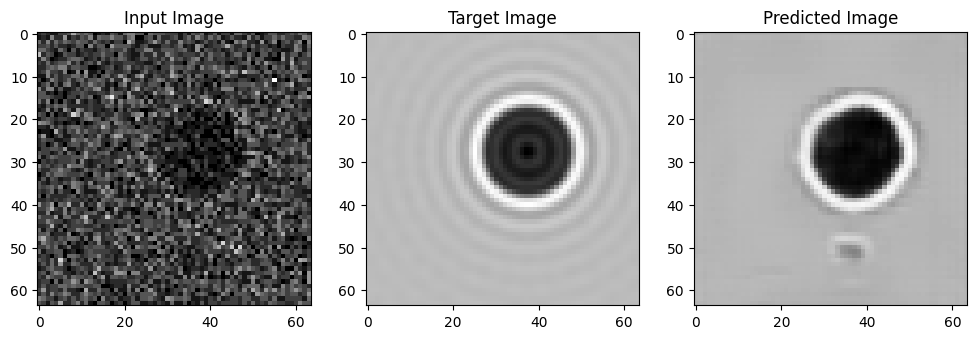

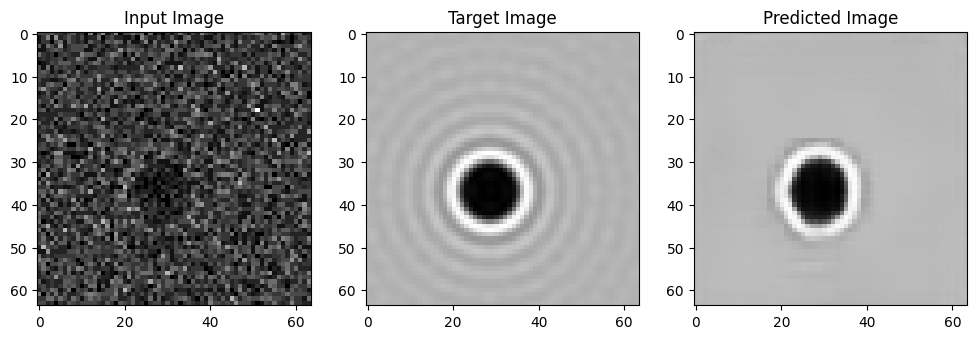

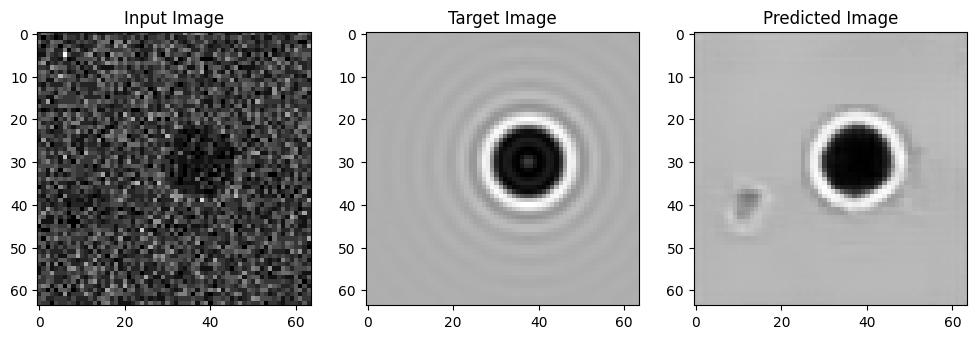

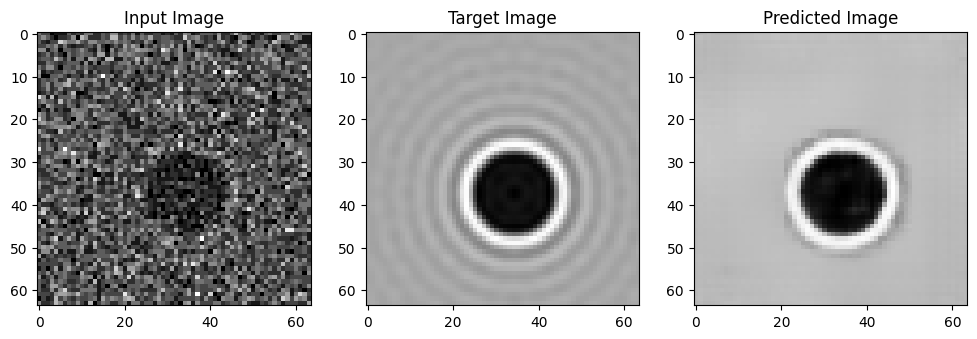

In [32]:
import matplotlib.pyplot as plt


for _ in range(4):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = new_autoencoder_regressor(input_im.unsqueeze(0)).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

## Improving the predictions
We can use a model with a larger number of activations to improve the results.

In [33]:
import deeplay as dl
from torch.nn import Sigmoid

better_autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[8, 16, 32],
    decoder_channels=[32, 16, 8],
    out_channels=1,
    out_activation=Sigmoid,
)
print(better_autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=8)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (3): PoolLayerActivationNormalizat

In [34]:
better_regressor_template = dl.Regressor(
    model=better_autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)

better_autoencoder_regressor = better_regressor_template.create()

better_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

better_autoencoder_trainer.fit(better_autoencoder_regressor, new_train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              | 0     
3 | test_metrics  | MetricCollection              | 0     
4 | model         | ConvolutionalEncoderDecoder2d | 15.1 K
5 | optimizer     | Adam                          | 0     
-------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


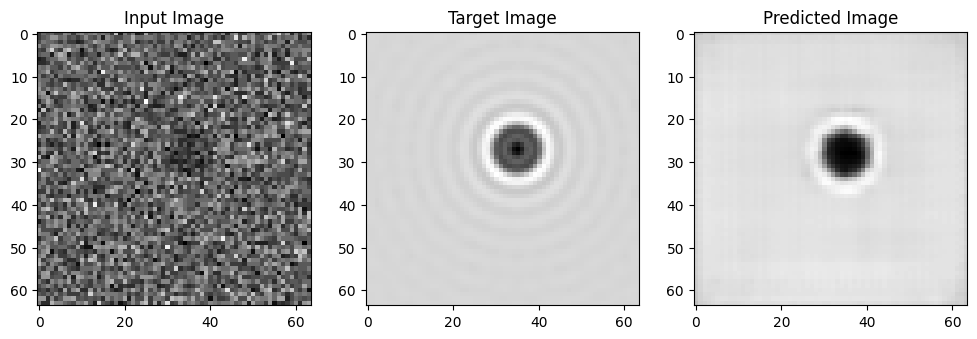

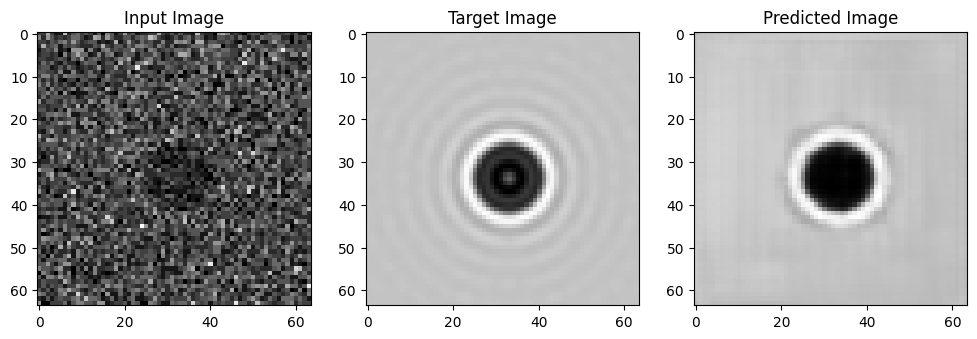

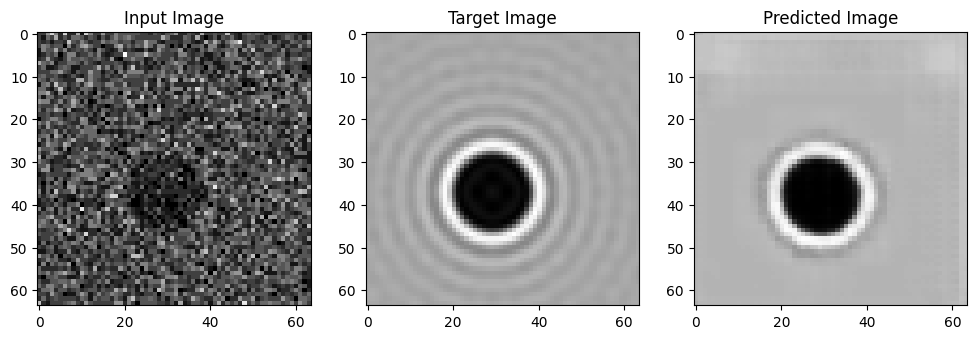

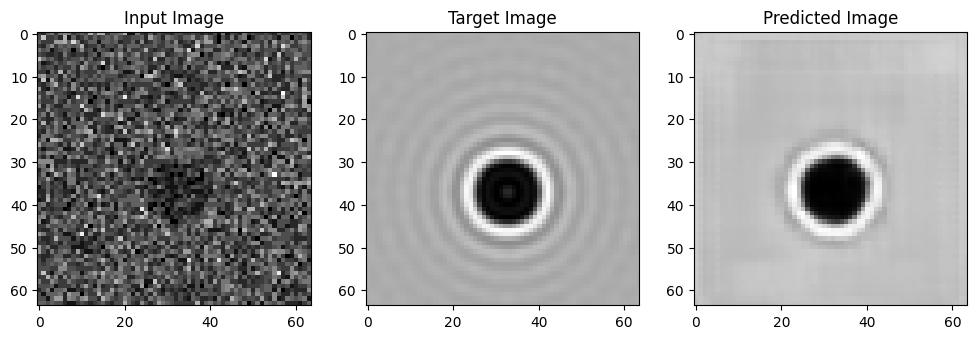

In [35]:
for _ in range(4):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = better_autoencoder_regressor(input_im.unsqueeze(0)).detach()

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")